In [18]:
import os
import time
import numpy as np 

In [19]:
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables import tpcf
from halotools.empirical_models.factories.mock_helpers import three_dim_pos_bundle

In [39]:
import matplotlib.pyplot as plt
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
%matplotlib inline

In [44]:
from ccppabc.code.data import data_RR
from ccppabc.code.data import data_random
from ccppabc.code.data import xi_binedges
from ccppabc.code.data import data_cov

## $\xi$ bin edges:

In [22]:
xi_bin = xi_binedges()
print xi_bin

[  0.15         0.5          0.65073304   0.84690699   1.10222073
   1.4345029    1.86695688   2.42978107   3.16227766   4.11559714
   5.35631011   6.97105597   9.07259295  11.80767206  15.36728477  20.        ]


In [23]:
init_time = time.time()
# initialize hod model
model = PrebuiltHodModelFactory('zheng07')
halocat = CachedHaloCatalog(simname='multidark', redshift=0, halo_finder='rockstar')

full_randoms = data_random(box='md_all')
full_RR = data_RR(box='md_all')
full_NR = len(full_randoms)
print time.time() - init_time, ' sec'

53.01354599  sec


In [24]:
rmax = xi_bin.max()
full_approx_cell1_size = [rmax, rmax, rmax]
full_approx_cellran_size = [rmax, rmax, rmax]

In [25]:
model.populate_mock(halocat, enforce_PBC=False)

In [26]:
full_pos = three_dim_pos_bundle(model.mock.galaxy_table, 'x', 'y', 'z')

In [27]:
xi_time = time.time()
full_xi = tpcf(full_pos, xi_bin, 
                       randoms=full_randoms, 
                       do_auto=True, do_cross=False, max_sample_size=int(full_pos.shape[0]), 
                       estimator='Natural', 
                       approx_cell1_size=full_approx_cell1_size, 
                       approx_cellran_size=full_approx_cellran_size, 
                       RR_precomputed=full_RR, 
                       NR_precomputed=full_NR)
print time.time() - xi_time

7.92286491394


In [28]:
import ccppabc.code.util as Util

In [29]:
# initialize subvolume halotools
sub_model = PrebuiltHodModelFactory('zheng07')
sub_model.new_haloprop_func_dict = {'sim_subvol': Util.mk_id_column}
sub_halocat = CachedHaloCatalog(simname='multidark', redshift=0, halo_finder='rockstar')

sub_randoms = data_random(box='md_sub')
sub_RR = data_RR(box='md_sub')
sub_NR = len(sub_randoms)

In [56]:
Nsub = 20

In [57]:
sub_xi_list = []
for ii in range(1,Nsub+1): 
    simsubvol = lambda x: Util.mask_func(x, ii)
    sub_model.populate_mock(sub_halocat, masking_function=simsubvol, enforce_PBC=False)
    
    sub_pos = three_dim_pos_bundle(sub_model.mock.galaxy_table, 'x', 'y', 'z')
    
    xi, yi, zi = Util.random_shifter(ii)
    temp_randoms = sub_randoms.copy()
    temp_randoms[:,0] += xi
    temp_randoms[:,1] += yi 
    temp_randoms[:,2] += zi
    
    sub_xi = tpcf(sub_pos, xi_bin, 
                 randoms=temp_randoms, 
                 do_auto=True, 
                 do_cross=False, 
                 max_sample_size=int(sub_pos.shape[0]), 
                 estimator='Natural', 
                 approx_cell1_size=full_approx_cell1_size, 
                 approx_cellran_size=full_approx_cellran_size, 
                 RR_precomputed=sub_RR, 
                 NR_precomputed=sub_NR)
    sub_xi_list.append(sub_xi)

In [58]:
tot_sub_xi = np.zeros(len(full_xi))
for sub_xi_i in sub_xi_list: 
    tot_sub_xi += sub_xi_i

avg_sub_xi = tot_sub_xi / np.float(Nsub)

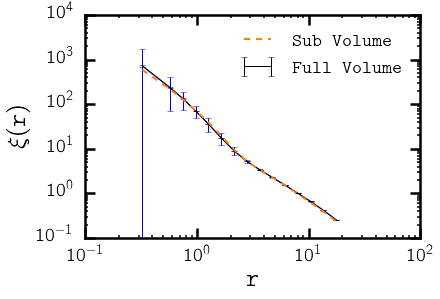

In [67]:
xi_cov_poisson = data_cov(inference='abc')[1:16, 1:16] # Poisson Covariance Matrix
sigma_poisson = np.diag(xi_cov_poisson)

xi_cov_cv = data_cov(inference='mcmc')[1:16, 1:16]
sigma_cv = np.diag(xi_cov_cv)

prettyplot() 
fig = plt.figure()
sub = fig.add_subplot(111)
sub.errorbar(0.5*(xi_bin[:-1] + xi_bin[1:]), full_xi, yerr=sigma_cv, c='b')
sub.errorbar(0.5*(xi_bin[:-1] + xi_bin[1:]), full_xi, yerr=sigma_poisson, c='k', label='Full Volume')
sub.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), avg_sub_xi, lw=2, ls='--', c=prettycolors()[3], label='Sub Volume')
sub.set_yscale('log')
sub.set_ylabel(r'$\xi\mathtt{(r)}$', fontsize=25)
sub.set_xscale('log')
sub.set_xlabel(r'$\mathtt{r}$', fontsize=25)
sub.legend(loc='upper right')
plt.show()

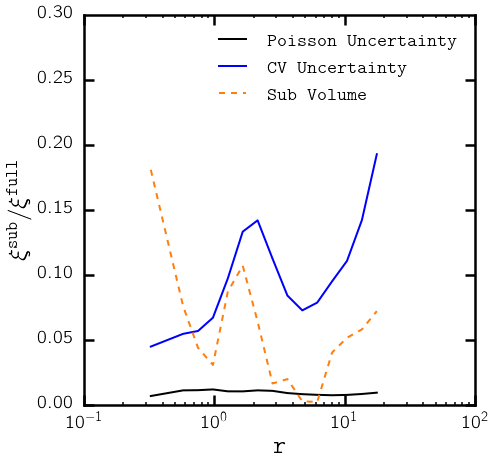

In [70]:
prettyplot() 
fig = plt.figure(figsize=(7, 7))
sub = fig.add_subplot(111)
sub.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), np.sqrt(sigma_poisson)/full_xi, lw=2, ls='-', c='k', label='Poisson Uncertainty')
sub.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), np.sqrt(sigma_cv)/full_xi, lw=2, ls='-', c='b', label='CV Uncertainty')
sub.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), np.abs(1 - avg_sub_xi/full_xi), lw=2, ls='--', c=prettycolors()[3], label='Sub Volume')
sub.set_ylim([0.0, 0.3])
sub.set_ylabel(r'$\xi^\mathtt{sub}/\xi^\mathtt{full}$', fontsize=25)
sub.set_xscale('log')
sub.set_xlabel(r'$\mathtt{r}$', fontsize=25)
sub.legend(loc='upper right')
plt.show()

$$\chi^2 = \frac{(\xi^{full} - \xi^{sub})^2}{2 \sigma_{poisson}^2}$$

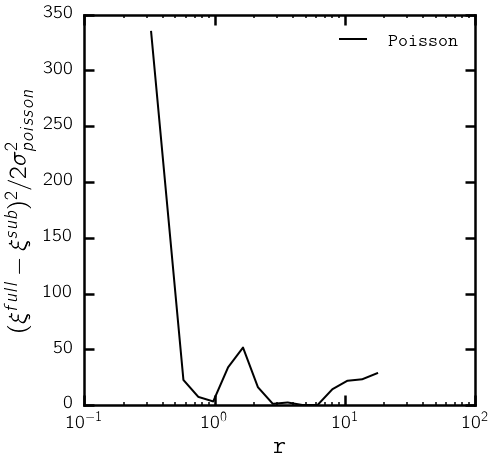

In [76]:
prettyplot() 
fig = plt.figure(figsize=(7, 7))
sub = fig.add_subplot(111)
sub.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), 0.5 * (full_xi - avg_sub_xi)**2/sigma_poisson, lw=2, ls='-', c='k', label='Poisson')
sub.set_ylabel(r'$(\xi^{full} - \xi^{sub})^2/{2 \sigma_{poisson}^2}$', fontsize=25)
sub.set_xscale('log')
sub.set_xlabel(r'$\mathtt{r}$', fontsize=25)
sub.legend(loc='upper right')
plt.show()

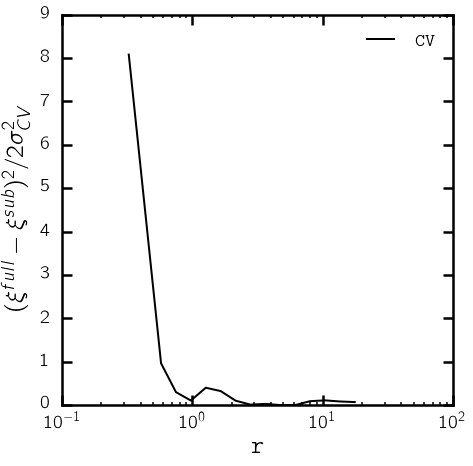

In [78]:
prettyplot() 
fig = plt.figure(figsize=(7, 7))
sub = fig.add_subplot(111)
sub.plot(0.5*(xi_bin[:-1] + xi_bin[1:]), 0.5 * (full_xi - avg_sub_xi)**2/sigma_cv, lw=2, ls='-', c='k', label='CV')
sub.set_ylabel(r'$(\xi^{full} - \xi^{sub})^2/{2 \sigma_{CV}^2}$', fontsize=25)
sub.set_xscale('log')
sub.set_xlabel(r'$\mathtt{r}$', fontsize=25)
sub.legend(loc='upper right')
plt.show()